In [1]:
# %load include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from IPython import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

# Introduction

The goal of this project is to be able to classify scintillation pulses by the type of incident radiation that triggered them, for the purpose of identifying the composition of said incident radiation. Radiation incident on a scintillator material, in this case polyethylene naphthalate (PEN), will eject either electrons or protons from molecules in that scintillator. Those ejected charged particles will ionize nearby atoms as they pass by them, and when those newly created ions recapture their electrons, they are initially in excited states. When those excited states decay to lower energy states, they produce characteristic pulses of photons, i.e., scintillation.

Ejected electrons and protons create scintillation pulses of different shapes. When ions recapture their electrons, they are equally likely to end up in a singlet or triplet excited state. Singlet excited states can decay quickly, and thus quickly produce scintillation, but in order for triplet states to decay quickly, though not quite as quickly as singlet states, two triplet states need to interact with each other in a process called triplet-triplet annihilation. Otherwise a single triplet state will decay in time scales much longer than are relevant to scintillation. This is relevant because ejected electrons tend to move far too quickly to produce a high density of triplet states, so scintillation triggered by ejected electrons tends to come mostly from decaying singlet states, because there are not many triplet states that are able to meet and annihilate. Ejected protons, on the other hand, move much more slowly with the same energy, so they will produce a higher density of triplet states, leading to more triplet-triplet annihilation and a slightly longer scintillation pulse width. Thus scintillation pulses from both ejected electrons and protons increase from zero to maximum luminosity similarly quickly, but scintillation pulses from ejected protons will have longer "tails" than those from ejected electrons.

The figure below shows an electron pulse and proton pulse superimposed over each other. Note how the proton pulse in blue has a longer decay time, i.e., pulse tail, than the electron pulse.

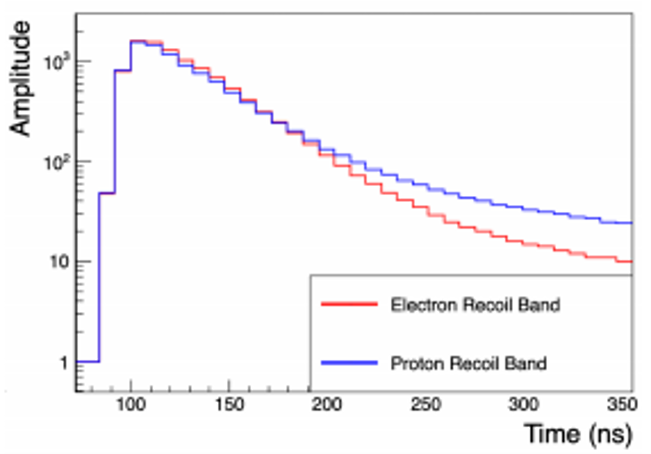

In [2]:
display.Image("./Electron_and_Proton_Pulses.png")

The traditional method of classifying scintillation pulses by the type of incident radiation that triggered them is a calculation known as Pulse Shape Discrimination (PSD). To calculate the PSD of a given scintillation pulse, you first choose a section of that pulse to designate the "short gate." The short gate should be a region of the pulse that has a characteristic shape ideally unique to pulses generated by a specific type of incident radiation. In the figure below, in the right plot, you can see that the electron pulse and proton pulse start to diverge at a specific point. Thus one could designate the short gate to be from that point through the rest of the tail. PSD is simply the area under the pulse within the short gate divided by the area under the entire pulse.

The plot on the left is a histogram of PSD calculations for many different events. Within that plot, the left peak corresponds to pulses triggered by ejected electrons, and the right peak corresponds to pulses triggered by ejected protons. As you can see, there is some degree of overlap between these two peaks. In this region, the traditional PSD calculation cannot tell us whether a given pulse is from an ejected electron or proton. The goal of this project is to be able classify such events that the traditional PSD calculation cannot.

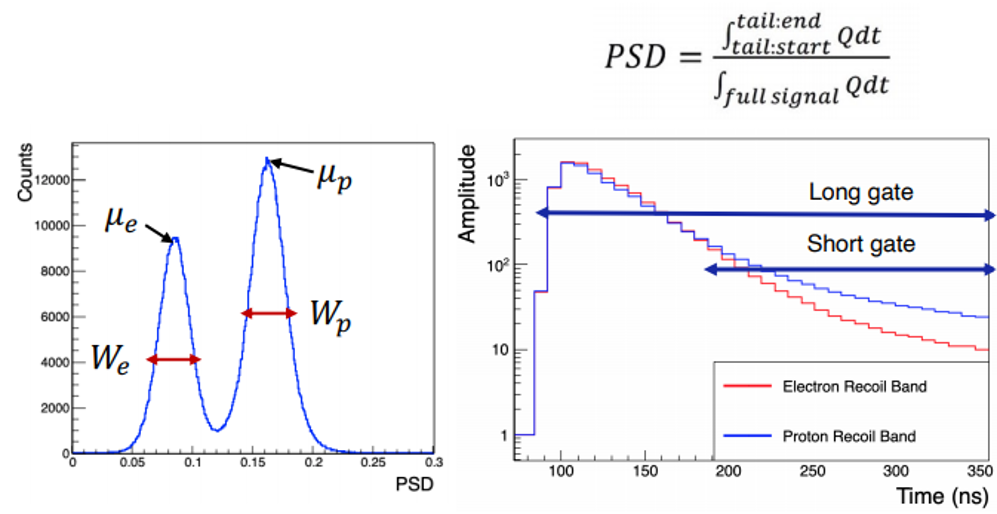

In [3]:
display.Image("./PSD_Plots.png")

# Data

The data I am using comes from an R&D effort within the LEGEND experiment to investigate scintillation potential of PEN. In this experiment, either protons or alpha particles travel down the silver vacuum tube pictured below and collide with LiF or C foil, respectively, mounted on a tantalum backing. Both these nuclear reactions emit neutrons in all directions, but with characteristic energies at each angle. The black cylinder is a PMT that can swivel around the reaction point to capture neutrons with different energies. Secured to the front of the PMT is a PEN tile which creates the scintillation pulses detected by the PMT.

Along with neutrons, gamma rays from ever present background interactions also create scintillation in the PEN tile. Thus the two types of incident radiation that create the data I am using here are gamma rays and neutrons. Gamma rays will eject electrons from molecules in the PEN tile, while neutrons will produce nuclear recoils in hydrogen atoms, i.e., they will eject protons.

The specific data I am using comes in the form of two data files: one file of all gamma pulses, one file of all neutron pulses. Each data file has 10,000 events, and each event is presented as a histogram with 200 bins each. Each bin is a single sample taken over 4 ns. I have two sets of two data files: "good quality" data giving high energy (1 - 4.5 MeV) gamma and neutron pulses with minimal background noise, and "medium quality" data giving medium-to-high energy (.45 - 4.5 MeV) gamma and neutron pulses with somewhat more background noise. The energy ranges given above refer to the energy deposition into the scintillator by the incident radiation, either gamma rays or neutrons.

With this data I hope to learn how accurate a binary classification neural network is at classifying a given pulse as either a gamma pulse or a neutron pulse.

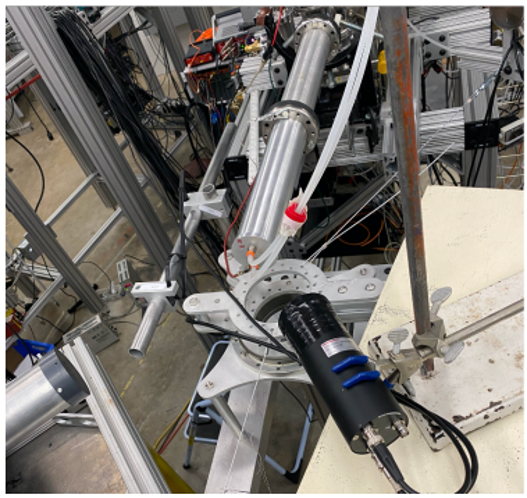

In [4]:
display.Image("./Notre_Dame_Apparatus.png")

# Machine Learning Procedure

The neural network I used is a Sequential model within the Keras API, using Dense layers. My final layer is a single neuron using the sigmoid activation function, and cost function is binary cross entropy, meaning my neural network is a binary classification algorithm. I feed into the neural network a list of lists, where the outer list is all the pulses in my data, and the inner lists are each individual pulse. Alongside my events list, I feed in a list of labels, 0's and 1's, that label each pulse as either a gamma pulse (0) or a neutron pulse (1).

Below is my initial code, where I take in the two data files containing gamma pulses and neutron pulses, strip the data files of tabs, spaces, and line breaks, and feed the data into a list of gamma events and a list of neutron events. Here you can see I am currently feeding in my "medium quality" data, but to feed in the "good quality" data, all you have to do is delete "_medium" from the text file names.

In [5]:
gamma_events = []

neutron_events = []

with open("gamma_pulses_medium.txt", "r") as data_file:
    
    for line in data_file:
        
        stripped_line = line.strip("\n").strip()
        
        list_line = stripped_line.split("\t")
        
        one_event = []
        
        for i in list_line:
            
            one_event.append(float(i))
        
        gamma_events.append(one_event)

with open("neutron_pulses_medium.txt", "r") as data_file:
    
    for line in data_file:
        
        stripped_line = line.strip("\n").strip()
        
        list_line = stripped_line.split("\t")
        
        one_event = []
        
        for i in list_line:
            
            one_event.append(float(i))
        
        neutron_events.append(one_event)

Next I randomly sort the pulses from the previous two lists into a single list of all pulses, gamma and neutrons. If a given pulse put into this "all_events" list is a gamma pulse, I additionally put a zero into a labels list. If the given pulse is a neutron pulse, I put a one into the labels list.

The method I used for randomly sorting the pulses into the all_events list is probably not optimal, but I believe it is suitable for my purposes. For each event I randomly choose either 0 or 1. If I choose 0, I put a gamma event into the list "first_half_events" and a neutron event into the list "second_half_events." If I choose 1, vice versa. So essentially I create two lists of randomly chosen gamma and neutron pulses, and then at the end I just add those two lists together to make one master list.

In [6]:
first_half_events = []

first_half_labels = []

second_half_events = []

second_half_labels = []

for i in range(len(gamma_events)):
    
    r = np.random.choice([0, 1])
    
    if (r == 0):
        
        first_half_events.append(gamma_events[i])
        
        first_half_labels.append(0)
        
        second_half_events.append(neutron_events[i])
        
        second_half_labels.append(1)
        
    else:
        
        first_half_events.append(neutron_events[i])
        
        first_half_labels.append(1)
        
        second_half_events.append(gamma_events[i])
        
        second_half_labels.append(0)

all_events = first_half_events + second_half_events

all_labels = first_half_labels + second_half_labels

Now that I have created my master list of all pulses, somewhat randomly ordered, plus a corresponding list of 0's and 1's acting as labels, I feed those two lists into my neural network.

First I split the inputs into training and testing data, where 90% of the data is kept for training. My neural network has an initial layer with a number of neurons equal to the number of data points in a single pulse, i.e., 200 neurons. After that I have settled on several wide layers, which seem to give some small advantage over a greater number of "skinnier" layers, at least for the "good quality" data. I will discuss later on the different neural network shapes I have tried and the results I found. Each layer has a ReLU activation function, except for the final layer, which necessarily has a sigmoid activation function. I also added in a Dropout layer, which appears to increase the accuracy of the neural network.

As mentioned before, since I am creating a binary classification algorithm, I am using the binary cross entropy cost function. For my optimizer I am using Adaptive Moment Estimation (Adam). I have a batch size of 64 and I run for 20 epochs. I plot both model accuracy and loss versus epoch. To evaluate the model, I use the neural network to predict whether each pulse is a gamma or neutron pulse, where an output of greater than or equal to .5 is a neutron event, and less than .5 is a gamma event. Then I compare my predictions to the given labels to find how many mistakes the neural network made.

One quirk I have found is that after I run the neural network, I have to rerun all the code above before running the neural network again, or else I will get an error message. I am not certain why that is the case.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 45,401
Trainable params: 45,401
Non-trainable params: 0
____________________________________________________

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Num. Mistakes  = 737


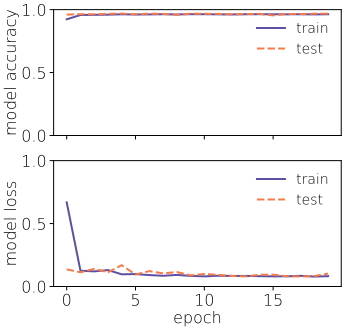

In [7]:
x_train, x_test, y_train, y_test = train_test_split(all_events, all_labels, test_size=0.1)

model = keras.Sequential(
[
    layers.Dense(100, input_shape=(len(gamma_events[0]),), activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy']) 

batch_size = 64
epochs = 20

training_history = {}
training_history['test'] = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test), verbose=1)

# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history['test'].history['accuracy'])
ax[0].plot(training_history['test'].history['val_accuracy'], ls='--', color=colors[-3])
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history['test'].history['loss'])
ax[1].plot(training_history['test'].history['val_loss'], ls='--', color=colors[-3])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');

# evaluate model
score = model.evaluate(x_test, y_test, verbose=2)

all_events = np.array(all_events)

predictions = np.zeros(all_events.shape[0],dtype=int)
predictions[np.where(model(all_events)>=0.5)[0]] = 1

mistakes = np.where(all_labels != predictions)[0]
num_mistakes = len(mistakes)

print(f'Num. Mistakes  = {num_mistakes}')

# Verifying the Code

I tried many different values for all available hyperparameters, I tried using differently shaped neural networks - both "tall and skinny" and "short and wide," and some networks in between - and all of it appeared to have very little impact on the performance of my neural network. For my "good quality" data, I always get >99% accuracy, and for my "medium quality" data, I always get in the range of 95-97% accuracy. The only factor I have found that seems to consistently improve results was adding  a Dropout layer. Doing so raised the accuracy range from 95-96% to 96-97%.

To check the quality of my code, I also ran a logistic regression algorithm, which got about 95.5% accuracy for "medium quality" data. So at the very least my neural network appears to be outperforming logistic regression.

In [8]:
logreg = LogisticRegression(C=1e5, max_iter=10000)

logreg.fit(all_events, all_labels)

performance = logreg.score(all_events, all_labels)

print("Performance of logistic regression:", performance)

Performance of logistic regression: 0.957


/lustre/haven/proj/UTK0154/local/envs/ml4s/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The other method of checking the quality of my code that I attempted was to calculate PSD for my data set the traditional way, but at this time I do not believe this code is working entirely correctly, or if it is it is producing some strange results. In order to be sure, I need to consult with the graduate student who is supplying me with my data, but I have been unable to get in contact with her for several days, so I have been unable to address this potential issue.

To calculate the short gate value, first I find the peak of a given pulse by finding the bin with the maximum value in that pulse. Then I sum up all the bins between 20 bins after the peak to 100 bins after the peak. "After the peak" means towards the tail of the pulse.

For the long gate, I follow the same procedure except I use all the bins between 10 bins before the peak to 100 bins after the peak. I realize that 111 bins is not the entire pulse of 200 bins, as I said before that the long gate is the area under the entire pulse. I do not know why this discrepancy exists: this is one of the questions I would ask the graduate student who is helping me with this, were I able to get in contact with her. But perhaps this discrepancy is why my results in this section seem off.

Below I isolate the short and long gates for all gamma pulses.

In [9]:
all_short_gates_G = []

all_long_gates_G = []

for i in range(len(gamma_events)):
    
    max_index = gamma_events[i].index(max(gamma_events[i]))
    
    short_gate = []
    
    for j in range(81):
        
        temp = max_index + 20 + j
        
        if temp < len(gamma_events[i]):
            
            adj_index = temp
            
            short_gate.append(gamma_events[i][adj_index])
            
        else:
            
            adj_index = len(gamma_events[i]) - 1
            
            short_gate.append(gamma_events[i][adj_index])
            
            break
            
    all_short_gates_G.append(short_gate)

for i in range(len(gamma_events)):
    
    max_index = gamma_events[i].index(max(gamma_events[i]))
    
    long_gate = []
    
    for j in range(1, 11):
        
        temp = max_index - j
        
        if temp >= 0:
            
            adj_index = temp
            
            long_gate.append(gamma_events[i][adj_index])
            
        else:
            
            adj_index = 0
            
            long_gate.append(gamma_events[i][adj_index])
            
            break
            
    for j in range(101):
        
        temp = max_index + j
        
        if temp < len(gamma_events[i]):
            
            adj_index = temp
            
            long_gate.append(gamma_events[i][adj_index])
            
        else:
            
            adj_index = len(gamma_events[i]) - 1
            
            long_gate.append(gamma_events[i][adj_index])
            
            break
            
    all_long_gates_G.append(long_gate)

Next I sum up all the bins within each short and long gate.

In [10]:
short_gate_integrals_G = []

long_gate_integrals_G = []

for i in range(len(all_short_gates_G)):
    
    integral = 0
    
    for j in range(len(all_short_gates_G[i])):
        
        integral += all_short_gates_G[i][j]
        
    short_gate_integrals_G.append(integral)
    
for i in range(len(all_long_gates_G)):
    
    integral = 0
    
    for j in range(len(all_long_gates_G[i])):
        
        integral += all_long_gates_G[i][j]
        
    long_gate_integrals_G.append(integral)

Finally I calculate all the PSD values for the all the gamma pulse events.

In [11]:
PSD_G = []

for i in range(len(gamma_events)):
    
    PSD_G.append(short_gate_integrals_G[i] / long_gate_integrals_G[i])

This long block of code is exactly the same as above, but for all the neutron pulses instead of gamma pulses.

In [12]:
all_short_gates_N = []

all_long_gates_N = []

for i in range(len(gamma_events)):
    
    max_index = gamma_events[i].index(max(gamma_events[i]))
    
    short_gate = []
    
    for j in range(81):
        
        temp = max_index + 20 + j
        
        if temp < len(gamma_events[i]):
            
            adj_index = temp
            
            short_gate.append(gamma_events[i][adj_index])
            
        else:
            
            adj_index = len(gamma_events[i]) - 1
            
            short_gate.append(gamma_events[i][adj_index])
            
            break
            
    all_short_gates_N.append(short_gate)

for i in range(len(gamma_events)):
    
    max_index = gamma_events[i].index(max(gamma_events[i]))
    
    long_gate = []
    
    for j in range(1, 11):
        
        temp = max_index - j
        
        if temp >= 0:
            
            adj_index = temp
            
            long_gate.append(gamma_events[i][adj_index])
            
        else:
            
            adj_index = 0
            
            long_gate.append(gamma_events[i][adj_index])
            
            break
            
    for j in range(101):
        
        temp = max_index + j
        
        if temp < len(gamma_events[i]):
            
            adj_index = temp
            
            long_gate.append(gamma_events[i][adj_index])
            
        else:
            
            adj_index = len(gamma_events[i]) - 1
            
            long_gate.append(gamma_events[i][adj_index])
            
            break
            
    all_long_gates_N.append(long_gate)

short_gate_integrals_N = []

long_gate_integrals_N = []

for i in range(len(all_short_gates_N)):
    
    integral = 0
    
    for j in range(len(all_short_gates_N[i])):
        
        integral += all_short_gates_N[i][j]
        
    short_gate_integrals_N.append(integral)
    
for i in range(len(all_long_gates_N)):
    
    integral = 0
    
    for j in range(len(all_long_gates_N[i])):
        
        integral += all_long_gates_N[i][j]
        
    long_gate_integrals_N.append(integral)

PSD_N = []

for i in range(len(gamma_events)):
    
    PSD_N.append(short_gate_integrals_N[i] / long_gate_integrals_N[i])

Below I plot a histogram of all PSD values for gamma pulses and neutron pulses. Note that this plot should ostensibly look like the previous PSD histogram in my Introduction section, but instead the PSD values for gamma and neutron pulses are largely overlapping. The gamma pulse PSD values are in red and the neutron pulse PSD values are in green. Taken at face value, this plot would suggest that the traditional PSD calculation is largely incapable of distinguishing between these particular gamma and neutron pulses, but I do not believe that is the case.

So unfortunately, thus far calculating the PSD the traditional way has not been a useful comparison to the performance of my neural network.

In [13]:
plt.hist(PSD_G, bins=len(PSD_G), color='r')

plt.hist(PSD_N, bins=len(PSD_N), color='g')

plt.ylabel('Counts')

plt.xlabel('PSD');

# Meaning of Final Results

Given that my neural network achieved >99% accuracy for "good quality" data and 96-97% accuracy for "medium quality" data, I would say that at the very least this method has shown promise for the task of distinguishing between gamma ray scintillation pulses and neutron scintillation pulses. But it also appears that, at least with the methods I have used so far, there is not that much room for improving the performance of the neural network.

Moving forward, I would like to try larger scale alterations to the neural network, beyond just fiddling with hyperparameters and network shape. The biggest change I would like to make is to turn this code into a nonbinary classification algorithm, sorting each pulse between three categories: gamma pulse, neutron pulse, and everything else. Another idea would be to look into recurrent neural networks, which at this moment I know nothing about. I could also try adding some random noise or other kind of structure to my input data using data augmentation, or using a "majority rule" method, where in I run the same neural network three times on the same data, and have them "vote" on what each pulse should be classified as.

# References

Thank you to Yuri Efremenko, Brennan Hackett and Jesse Harris

B. Hackett, R. Toomey, “Measurement of Luminescent Properties of Polyethylene 2,6-Naphthalate,” (2021).

Hackett, Brennan. Scintillation and Optical Properties of the Low-Background Scintillator, PEN. 2021. PowerPoint Presentation.

J. Harris, “An A.I. Approach to Higgs Decay,” (2020).